In [1]:
import warnings

warnings.filterwarnings("ignore")

# Learning goals
After today's lesson you should be able to:
- Understand the differences between SLX, spatial lag and spatial error models
- Identify when to use different kinds of models
- Implement all three types of models in pysal
- Check our model outcomes 

This week's lesson is a simplied version of:  
- The [Week 11 on Spatial Regression the Geographic Data Science book](https://geographicdata.science/book/notebooks/11_regression.html)


In [2]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

## Data: San Diego Airbnb

To learn a little more about how regression works, we'll examine information about Airbnb properties in San Diego, CA. 
This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in Airbnb jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g., distance to Balboa Park, `d2balboa` or neighborhood id, `neighborhood_cleansed`).

Also, note that there is a great notebook in the Geographic Data Science book on [how this dataset was cleaned](https://geographicdata.science/book/data/airbnb/regression_cleaning.html). It has some example code for: 
- How to calculate the driving distance to a certain location (Balboa Park in this example) using a free API called Nomatim, since we only learned about the Google Maps API. 
- How to get the elevation of a location
- How to categorize neighborhoods (here, by size and whether they are coastal).
- Creating dummy variables


In [3]:
db = geopandas.read_file("https://www.dropbox.com/s/zkucu7jf1xug869/regression_db.geojson?dl=1")
# db['pool'] = db['pool'].astype(int)
# db['coastal'] = db['coastal'].astype(int)
# db['pg_Apartment'] = db['pg_Apartment'].astype(int)
# db['pg_Condominium'] = db['pg_Condominium'].astype(int)
# db['pg_House'] = db['pg_House'].astype(int)
# db['pg_Other'] = db['pg_Other'].astype(int)
# db['pg_Townhouse'] = db['pg_Townhouse'].astype(int)
# db['rt_Entire_home/apt'] = db['rt_Entire_home/apt'].astype(int)
# db['rt_Private_room'] = db['rt_Private_room'].astype(int)
# db['rt_Shared_room'] = db['rt_Shared_room'].astype(int)

Notice here that we have: 
- **Discrete variables** (number of bedrooms, beds, baths)
- **Dummy variables** (whether there is a pool, whether near the coast, room type)

**Remember that for dummy variables we always run the regression leaving out one category as our baseline.**

In [4]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


In [5]:
db.shape

(6110, 20)

These are the explanatory variables we will use throughout the chapter.

In [6]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

## Non-spatial regression, a (very) quick refresh
For example, in our case, we may want to express the price of a house as a function of the number of bedrooms it has and whether it is a condominium or not. At the individual level, we can express this as:

$$
log(P_i) = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where $P_i$ is the Airbnb price of house $i$, and $X$ is a set of covariates that we use to explain such price (e.g., No. of bedrooms and condominium binary variable). $\beta$ is a vector of parameters that give us information about in which way and to what extent each variable is related to the price, and $\alpha$, the constant term, is the average house price when all the other variables are zero. The term $\epsilon_i$ is usually referred to as "error" and captures elements that influence the price of a house but are not included in $X$.

We also take the log of prices often since a log scale allows us a better understanding of the percentage change instead of the absolute dollar change.  

We can also express this relation in matrix form, excluding sub-indices for $i$, which yields:

$$
log(P) = \alpha + \mathbf{X}\beta + \epsilon
$$

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g., `statsmodels`, `scikit-learn`, `pysal`). We will import the `spreg` module in Pysal:

In [7]:
from pysal.model import spreg

In the context of this chapter, it makes sense to start with `spreg`, as that is the only library that will allow us to move into explicitly spatial econometric models. To fit the model specified in the equation above with $X$ as the list defined, using ordinary least squares (OLS), we only need the following line of code:

In [8]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

We use the command `OLS`, part of the `spreg` sub-package, and specify the dependent variable (the log of the price, so we can interpret results in terms of percentage change) and the explanatory ones. Note that both objects need to be arrays, so we extract them from the `pandas.DataFrame` object using `.values`.

In order to inspect the results of the model, we can print the `summary` attribute:

In [9]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

Results are largely as expected: houses tend to be significantly more expensive if they accommodate more people (`accommodates`), if they have more bathrooms and bedrooms, and if they are a condominium or part of the "other" category of house type. Conversely, given a number of rooms, houses with more beds (i.e., listings that are more "crowded") tend to go for cheaper, as it is the case for properties where one does not rent the entire house but only a room (`rt_Private_room`) or even shares it (`rt_Shared_room`). Of course, you might conceptually doubt the assumption that it is possible to *arbitrarily* change the number of beds within an Airbnb without eventually changing the number of people it accommodates, but methods to address these concerns using *interaction effects* won't be discussed here. 

### Hidden structures

In general, our model performs well, being able to predict slightly about two-thirds ($R^2=0.67$) of the variation in the mean nightly price using the covariates we've discussed above.
But, our model might display some clustering in the errors, which may be a problem as that violates the i.i.d. assumption linear models usually come built-in with. 
To interrogate this, we can do a few things. 
One simple concept might be to look at the correlation between the error in predicting an Airbnb and the error in predicting its nearest neighbor. 
To examine this, we first might want to split our data up by regions and see if we've got some spatial structure in our residuals. 
One reasonable theory might be that our model does not include any information about *beaches*, a critical aspect of why people live and vacation in San Diego. 
Therefore, we might want to see whether or not our errors are higher or lower depending on whether or not an Airbnb is in a "beach" neighborhood, a neighborhood near the ocean. We use the code below to generate Figure XXX1XXX, which looks at prices between the two groups of houses, "beach" and "no beach".

Note here that `m1.u` are the residuals from the model `m1`. 

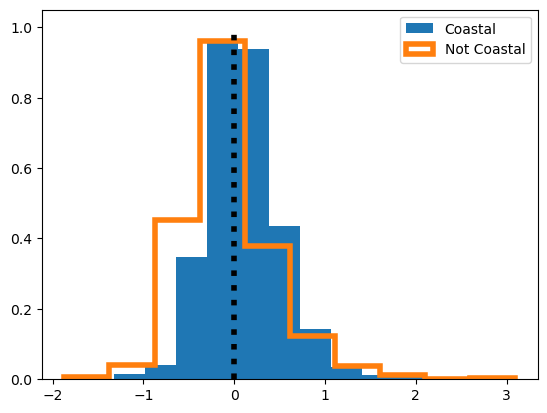

In [10]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

While it appears that the neighborhoods on the coast have only slightly higher average errors (and have lower variance in their prediction errors), the two distributions are significantly distinct from one another when compared using a classic $t$-test:

In [11]:
from scipy.stats import ttest_ind

ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

There are more sophisticated (and harder to fool) tests that may be applicable for this data, however. We cover them in the [Challenge](#Challenge) section. 

Additionally, it might be the case that some neighborhoods are more desirable than other neighborhoods due to unmodeled latent preferences or marketing. 
For instance, despite its presence close to the sea, living near Camp Pendleton -a Marine base in the North of the city- may incur some significant penalties on area desirability due to noise and pollution. These are questions that domain knowledge provides and data analysis can help us answer.
For us to determine whether this is the case, we might be interested in the full distribution of model residuals within each neighborhood. 

To make this more clear, we'll first sort the data by the median residual in that neighborhood, and then make a boxplot (Fig. XXX2XXX), which shows the distribution of residuals in each neighborhood:

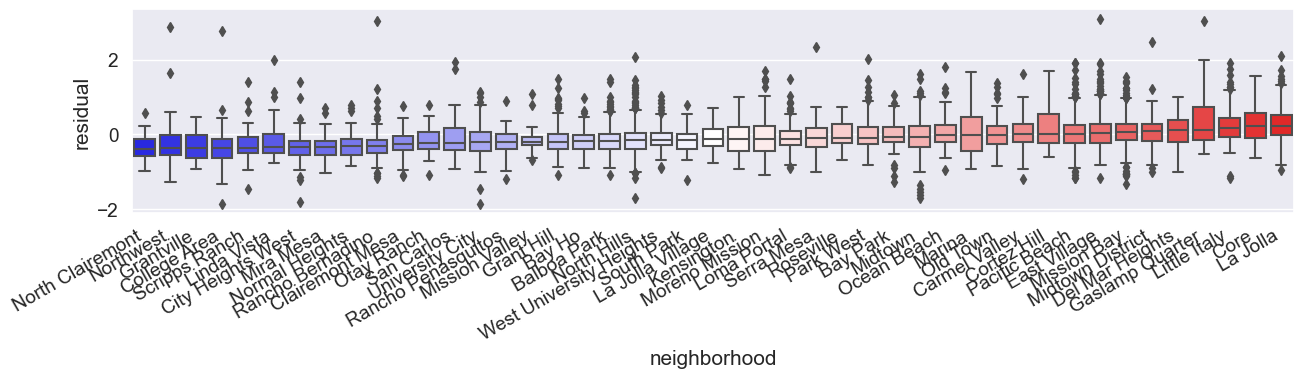

In [12]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (
    db.groupby("neighborhood")
    .residual.median()
    .to_frame("hood_residual")
)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    data=db.merge(
        medians, how="left", left_on="neighborhood", right_index=True
    ).sort_values("hood_residual"),
    x="neighborhood",
    y="residual",
    ax=ax,
    palette="bwr",
)
# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

No neighborhood is disjoint from one another, but some do appear to be higher than others, such as the well-known downtown tourist neighborhoods areas of the Gaslamp Quarter, Little Italy, or The Core. 
Thus, there may be a distinctive effect of intangible neighborhood fashionableness that matters in this model. 

Noting that many of the most over- and under-predicted neighborhoods are near one another in the city, it may also be the case that there is some sort of *contagion* or spatial spillovers in the nightly rent price. 
This often is apparent when individuals seek to price their Airbnb listings to compete with similar nearby listings. 
Since our model is not aware of this behavior, its errors may tend to cluster. 
**One exceptionally simple way we can look into this structure is by examining the relationship between an observation's residuals and its surrounding residuals.**

To do this, we will use *spatial weights* to represent the geographic relationships between observations. 
We cover spatial weights in detail in [Chapter 4](04_spatial_weights), so we will not repeat ourselves here.
For this example, we'll start off with a $KNN$ matrix where $k=1$, meaning we're focusing only on the linkages of each Airbnb to their closest other listing.

In [13]:
knn = weights.KNN.from_dataframe(db, k=1)

This means that, when we compute the *spatial lag* of that $KNN$ weight and the residual, we get the residual of the Airbnb listing closest to each observation.

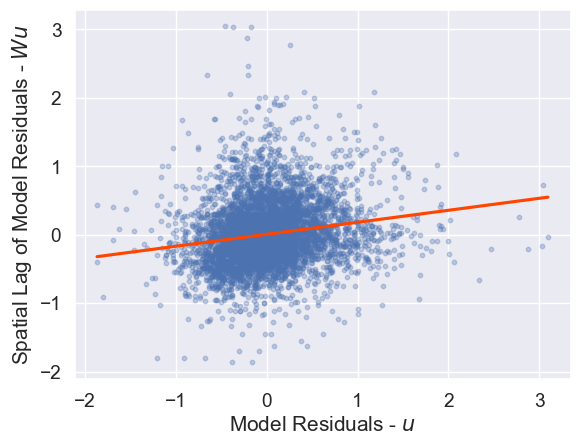

In [14]:
## Here lag_spatial is a function that returns the spatial lag of a variable
## given a certain set of weights

lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    scatter_kws={'alpha': 0.3,'s':10},
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

In Figure XXX3XXX, we see that our prediction errors tend to cluster!
Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it. 
Here, we're using this nearest site to stand in for the *surroundings* of that Airbnb. 
This means that, when the model tends to over-predict a given Airbnb's nightly log price, sites around that Airbnb are more likely to *also be over-predicted*. 

Let's look at the stable $k=20$ number of neighbors.
Examining the relationship between this stable *surrounding* average and the focal Airbnb, we can even find clusters in our model error. 
Recalling the *local Moran* statistics in [Chapter 7](07_local_autocorrelation), Figure XXX4XXX is generated from the code below to identify certain areas where our predictions of the nightly (log) Airbnb price tend to be significantly off:

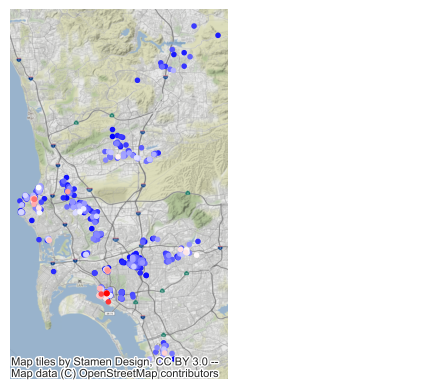

In [15]:
# Re-weight W to 20 nearest neighbors
knn = weights.KNN.from_dataframe(db, k=20)# Row standardize weights

knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    db.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off();

Thus, these areas tend to be locations where our model significantly under-predicts the nightly Airbnb price both for that specific observation and observations in its immediate surroundings. 
This is critical since, if we can identify how these areas are structured &mdash; if they have a *consistent geography* that we can model &mdash; then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas. Since significant under- and over-predictions do appear to cluster in a highly structured way, we might be able to use a better model to fix the geography of our model errors. 


### Spatial feature engineering: proximity variables
One relevant proximity-driven variable that could influence our San Diego model is based on the listings proximity to Balboa Park. A common tourist destination, Balboa Park is a central recreation hub for the city of San Diego, containing many museums and the San Diego Zoo. Thus, it could be the case that people searching for Airbnbs in San Diego are willing to pay a premium to live closer to the park. If this were true *and* we omitted this from our model, we may indeed see a significant spatial pattern caused by this distance decay effect. 

Therefore, this is sometimes called a *spatially patterned omitted covariate*: geographic information our model needs to make good predictions which we have left out of our model. Therefore, let's build a new model containing this distance to Balboa Park covariate. First, though, it helps to visualize (Fig. XXX5XXX) the structure of this distance covariate itself:

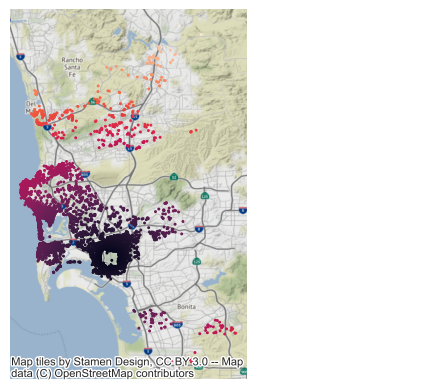

In [16]:
ax = db.plot("d2balboa", marker=".", s=5)
contextily.add_basemap(ax, crs=db.crs)
ax.set_axis_off();

To run a linear model that includes the additional variable of distance to the park, we add the name to the list of variables we included originally:

In [17]:
balboa_names = variable_names + ["d2balboa"]

And then fit the model using the OLS class in Pysal's `spreg`:

In [18]:
m2 = spreg.OLS(
    db[["log_price"]].values,
    db[balboa_names].values,
    name_y="log_price",
    name_x=balboa_names,
)

In [19]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
R-squared           :      0.6685
Adjusted R-squared  :      0.6679
Sum squared residual:    1319.522                F-statistic           :   1117.9338
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3987.446
Sigma-square ML     :       0.216                Akaike info criterion :    7998.892
S.E of regression ML:      0.4647                Schwarz criterion     :    8079.504

-----------------------------------------------------------------------------

When you inspect the regression diagnostics and output, you see that this covariate is not quite as helpful as we might anticipate:

In [20]:
pandas.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


And, there still appears to be spatial structure in our model's errors, as we can see in Figure XXX6XXX, generated by the code below:

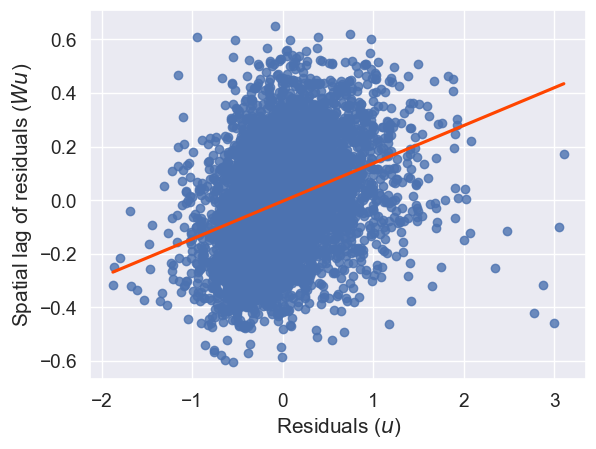

In [21]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = seaborn.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

Finally, the distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an Airbnb; the coefficient estimate is *positive*, meaning that people are paying a premium to be *further* from Balboa Park. We will revisit this result later on, when we consider spatial heterogeneity and will be able to shed some light on this. Further, the next chapter is an extensive treatment of spatial fixed effects, presenting many more spatial feature engineering methods. Here, we have only showed how to include these engineered features in a standard linear modeling framework. 

### Spatial heterogeneity

#### Spatial fixed effects
Mathematically, we are now fitting the following equation:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where the main difference is that we are now allowing the constant term, $\alpha$, to vary by neighborhood $r$, $\alpha_r$.

Programmatically, we will show two different ways we can estimate this: one,
using `statsmodels`; and two, with `spreg`. First, we will use `statsmodels`, the econometrician's toolbox in Python. 

In [22]:
import statsmodels.formula.api as sm

This package provides a formula-like API, which allows us to express the *equation* we wish to estimate directly:

In [23]:
f = (
    "log_price ~ "
    + " + ".join(variable_names)
    + " + neighborhood - 1"
)
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


The *tilde* operator in this statement is usually read as "log price is a function of ...", to account for the fact that many different model specifications can be fit according to that functional relationship between `log_price` and our covariate list. **Critically, note that the trailing `-1` term means that we are fitting this model without an intercept term. This is necessary, since including an intercept term alongside unique means for every neighborhood would make the underlying system of equations underspecified.**

Using this expression, we can estimate the unique effects of each neighborhood, fitting the model in `statsmodels` (note how the specification of the model, formula and data is separated from the fitting step): 

In [24]:
m3 = sm.ols(f, data=db).fit()

We could rely on the `summary2()` method to print a similar summary report from the regression but, given it is a lengthy one in this case, we will illustrate how you can extract the spatial fixed effects into a table for display.

In [25]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pandas.DataFrame(
    {
        "Coef.": m3.params[sfe_names],
        "Std. Error": m3.bse[sfe_names],
        "P-Value": m3.pvalues[sfe_names],
    }
)

,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


The approach above shows how spatial FE are a particular case of a linear regression with a categorical  variable. Neighborhood membership is modeled using binary dummy variables. Thanks to the formula grammar used in `statsmodels`, we can express the model abstractly, and Python parses it, appropriately creating binary variables as required.

The second approach leverages `spreg` Regimes functionality. We will see regimes below but, for now, think of them as a generalization of spatial fixed effects where not only $\alpha$ can vary. This framework allows the user to specify which variables are to be estimated separately for each group. In this case, instead of describing the model in a formula, we need to pass each element of the model as separate arguments.

In [26]:
# spreg spatial fixed effect implementation
## Note that we are using the new function OLS_Regimes

m4 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variable_names),
    # If True, a separate regression is run for each regime.
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [27]:
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6055
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:    1147.169                F-statistic           :    276.9408
Sigma-square        :       0.189                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3559.832
Sigma-square ML     :       0.188                Akaike info criterion :    7229.664
S.E of regression ML:      0.4333                Schwarz criterion     :    7599.137

---------------------------------------------------------

Similarly as above, we could rely on the `summary` attribute to print a report with all the results computed. For simplicity here, we will only confirm that, to the 12th decimal, the parameters estimated are indeed the same as those we get from `statsmodels`:

In [28]:
import numpy

numpy.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([-0.e+00, -1.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  1.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00, -0.e+00, -0.e+00,  0.e+00,
       -0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00])

To make a map of neighborhood fixed effects, we need to process the results from our model slightly.

First, we extract only the effects pertaining to the neighborhoods:

In [29]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

Then, we need to extract just the neighborhood name from the index of this Series. A simple way to do this is to strip all the characters that come before and after our neighborhood names:

In [30]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


Good, we're back to our raw neighborhood names. These allow us to join it to an auxillary file with neighborhood boundaries that is indexed on the same names. Let's read the boundaries first:

In [31]:
sd_path = 'http://data.insideairbnb.com/united-states/ca/san-diego/2022-12-24/visualisations/neighbourhoods.geojson'
neighborhoods = geopandas.read_file(sd_path)

And we can then merge the spatial FE and plot them on a map (Fig. XXX7XXX):

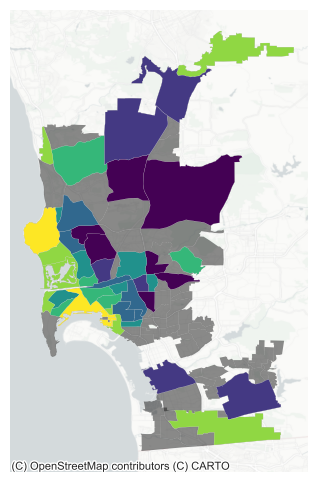

In [32]:
# Plot base layer with all neighborhoods in grey
ax = neighborhoods.plot(
    color="k", linewidth=0, alpha=0.5, figsize=(12, 6)
)
# Merge SFE estimates (note not every polygon
# receives an estimate since not every polygon
# contains Airbnb properties)
neighborhoods.merge(
    neighborhood_effects,
    how="left",
    left_on="neighbourhood",
    right_index=True
    # Drop polygons without a SFE estimate
).dropna(
    subset=["fixed_effect"]
    # Plot quantile choropleth
).plot(
    "fixed_effect",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=7,  # No. of classes in the choropleth
    linewidth=0.1,  # Polygon border width
    cmap="viridis",  # Color scheme
    ax=ax,  # Axis to draw on
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=neighborhoods.crs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

We can see a clear spatial structure in the SFE estimates. The most expensive neighborhoods tend to be located near the coast, while the cheapest ones are more inland.

#### Spatial regimes
The equation we will be estimating is:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

where we are not only allowing the constant term to vary by region ($\alpha_r$), but also every other parameter ($\beta_{k-r}$).

To illustrate this approach, we will use the "spatial differentiator" of whether a house is in a coastal neighborhood or not (`coastal_neig`) to define the regimes. The rationale behind this choice is that renting a house close to the ocean might be a strong enough pull that people might be willing to pay at different *rates* for each of the house's characteristics.

To implement this in Python, we use the `OLS_Regimes` class in `spreg`, which does most of the heavy lifting for us:

In [33]:
# Pysal spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["coastal"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

The result can be explored and interpreted similarly to the previous ones. If you inspect the `summary` attribute, you will find the parameters for each variable mostly conform to what you would expect, across both regimes. To compare them, we can plot them side-by-side on a bespoke table:

In [34]:
# Results table
res = pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.t_stat],
    },
    index=m5.name_x,
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pandas.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pandas.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pandas.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

An interesting question arises around the relevance of the regimes. *Are estimates for each variable across regimes statistically different?* For this, the model object also calculates for us what is called a **Chow test. This is a statistic that tests the null hypothesis that estimates from different regimes are undistinguishable. If we reject the null, we have evidence suggesting the regimes actually make a difference.**

Results from the Chow test are available on the `summary` attribute, or we can extract them directly from the model object, which we will do here. There are two types of Chow test. First is a global one that jointly tests for differences between the two regimes:

In [35]:
m5.chow.joint

(328.8690214302295, 7.113548767544617e-64)

The first value represents the statistic, while the second one captures the p-value. In this case, the two regimes are statistically different from each other. The next step then is to check whether each of the coefficients in our model differs across regimes. For this, we can pull them out into a table:

In [36]:
pandas.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


As we can see in the table, most variables do indeed differ across regimes, statistically speaking. This points to systematic differences in the data generating processes across spatial regimes.

### Spatial dependence

#### Exogenous effects: The SLX model
Now we estimate the following model:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

where $\sum_{j=1}^N w_{ij}x_{jk}$ represents the spatial lag of the $k$ th explanatory variable.
This can be stated in *matrix* form using the spatial weights matrix, $\mathbf{W}$, as:

$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

This splits the model to focus on two main effects: $\beta$ and $\gamma$. The
$\beta$ effect describes the change in $y_i$ when $X_{ik}$ changes by one. The subscript for site $i$ is important here: since we're dealing 
with a $\mathbf{W}$ matrix, it's useful to be clear about where the change occurs. The $\gamma$ effect represents the 
*indirect* association of a change in $X_i$ with the house price. 

This can be conceptualized in two ways. 
- First, one could think of $\gamma$ as simply *the association between the price in a given house and a unit change in its average surroundings.*
This is useful and simple. But this interpretation blurs *where* this change
might occur. In truth, a change in a variable at site $i$ will result in a *spillover* to its surroundings:
when $x_i$ changes, so too does the *spatial lag* of any site near $i$. 
The precise size of the change in the lag will depend on the structure of $\mathbf{W}$, and it can be 
different for every site it is connected with. For example, think of a very highly connected "focal" site in a 
row-standardized weight matrix. This focal site will not be strongly affected 
if a neighbor changes by a single unit, since each site only contributes a 
small amount to the lag at the focal site. 
- Alternatively, consider a site with only 
one neighbor: its lag will change by *exactly* the amount its sole neighbor changes.
Thus, to discover the exact indirect effect of a change $y$ caused by the change
at a specific site $x_i$ you would need to compute the *change in the spatial lag*,
and then use that as your *change* in $X$. We will discuss this in the following section. 

In Python, we can calculate the spatial lag of each variable whose name starts by `pg_`
by first creating a list of all of those names, and then applying `pysal`'s
`lag_spatial` to each of them:

In [37]:
# Select only columns in `db` containing the keyword `pg_`
lag_variables_used = db.filter(
        like="pg_"
        # Compute the spatial lag of each of those variables
    )
wx = lag_variables_used.apply(lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
wx = wx.rename(columns=lambda c: "w_"+ c
        # Remove the lag of the binary variable for apartments
    )
wx = wx.drop("w_pg_Apartment", axis=1)


Once computed, we can run the model using OLS estimation because, in this
context, the spatial  lags included do not violate any of the assumptions OLS
relies on (they are essentially additional exogenous variables):

In [38]:
# Merge original variables with the spatial lags in `wx`
slx_exog = db[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y="l_price",
    # Independent variables names
    name_x=slx_exog.columns.tolist(),
)

As in the previous cases, printing the `summary` attribute of the model object would show a full report table. The variables we included in the original regression
display similar behavior, albeit with small changes in size, and can be
interpreted also in a similar way. To focus on the aspects that differ from the previous models here, we will only pull out results for the variables for which we also included their spatial lags:

In [39]:
# Collect names of variables of interest
vars_of_interest = (
    db[variable_names].filter(like="pg_").join(wx).columns
)
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m6.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m6.t_stat],
    },
    index=m6.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1063,0.0222,0.0000
pg_House,0.0328,0.0157,0.0368
pg_Other,0.0862,0.0240,0.0003
pg_Townhouse,-0.0277,0.0338,0.4130
w_pg_Condominium,0.5928,0.0690,0.0000
w_pg_House,-0.0774,0.0319,0.0152
w_pg_Other,0.4851,0.0551,0.0000
w_pg_Townhouse,-0.2724,0.1223,0.0260


The spatial lag of each type of property
(`w_pg_XXX`) is the new addition. We observe that, except for the case
of townhouses (same as with the binary variable, `pg_Townhouse`), they are all
significant, suggesting our initial hypothesis on the role of the surrounding
houses might indeed be at work here. 

As an illustration, let's look at some of the direct/indirect effects. 
The direct effect of the `pg_Condominium` variable means that condominiums are
typically 11% more expensive ($\beta_{pg\_{Condominium}}=0.1063$) than the benchmark
property type, apartments. More relevant to this section, any given house surrounded by 
condominiums *also* receives a price premium. But, since $pg_{Condominium}$ is a dummy variable,
the spatial lag at site $i$ represents the *percentage* of properties near $i$ that are
condominiums, which is between $0$ and $1$.
So, a *unit* change in this variable means that you would increase the condominium 
percentage by 100%. Thus, a $1$ increase in `w_pg_Condominium` (a change of 100% percentage points)
would result in a 59.2% increase in the property house price ($\beta_{w_pg\_Condominium} = 0.5928$). 
Similar interpretations can be derived for all other spatially lagged variables to derive the
*indirect* effect of a change in the spatial lag. 




#### Spatial error

The spatial error model includes a spatial lag in the *error* term of the equation:

$$
\log{P_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

where $u_{lag-i} = \sum_j w_{i,j} u_j$. 

In [40]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

Similarly as before, the `summary` attribute will return a full-featured table of results. For the most part, it may be interpreted in similar ways to those above. The main difference is that, in this case, we can also recover an estimate and inference for the $\lambda$ parameter in the error term:

In [41]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m7.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m7.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m7.z_stat],
    },
    index=m7.name_x
    # Subset for lambda parameter and round to
    # four decimals
).reindex(["lambda"]).round(4)

,Coeff.,Std. Error,P-Value
lambda,0.6449,0.0187,0.0


#### Spatial lag

The spatial lag model introduces a spatial lag of the *dependent* variable. In the example we have covered, this would translate into:

$$
\log{P_i} = \alpha + \rho \log{P_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

In [42]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m8 = spreg.GM_Lag(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

And let's summarize the coefficients in a table as before (usual disclaimer about the `summary` object applies):

In [43]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m8.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m8.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m8.z_stat],
    },
    index=m8.name_z
    # Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,2.7440,0.0727,0.0000
accommodates,0.0698,0.0048,0.0000
bathrooms,0.1627,0.0104,0.0000
bedrooms,0.1604,0.0105,0.0000
beds,-0.0365,0.0065,0.0000
rt_Private_room,-0.4981,0.0151,0.0000
rt_Shared_room,-1.1157,0.0366,0.0000
pg_Condominium,0.1073,0.0209,0.0000
pg_House,-0.0004,0.0137,0.9766
pg_Other,0.1208,0.0215,0.0000


## Q.1

One common kind of spatial econometric model is the "Spatial Durbin Model," which combines the SLX model with the spatial lag model. Alternatively, the "Spatial Durbin Error Model" combines the SLX model with the spatial error model. 

- Fit a Spatial Durbin variant of the spatial models we have fit in this chapter.  (5 pts)
- Do these variants improve the model fit? (2 pts)
- What happens to the spatial autocorrelation parameters ($\rho$, $\lambda$) when the SLX term is added? Why might this occur? (5 pts)